## What we know

* Most leek leafminers died the first 2-3 days
* There were a lot of gnats from the soil (which was collected from outside)
* However, we saw one leafminer still alive the last day

## Leek leafminer (left) and Witloof leafminer (right)

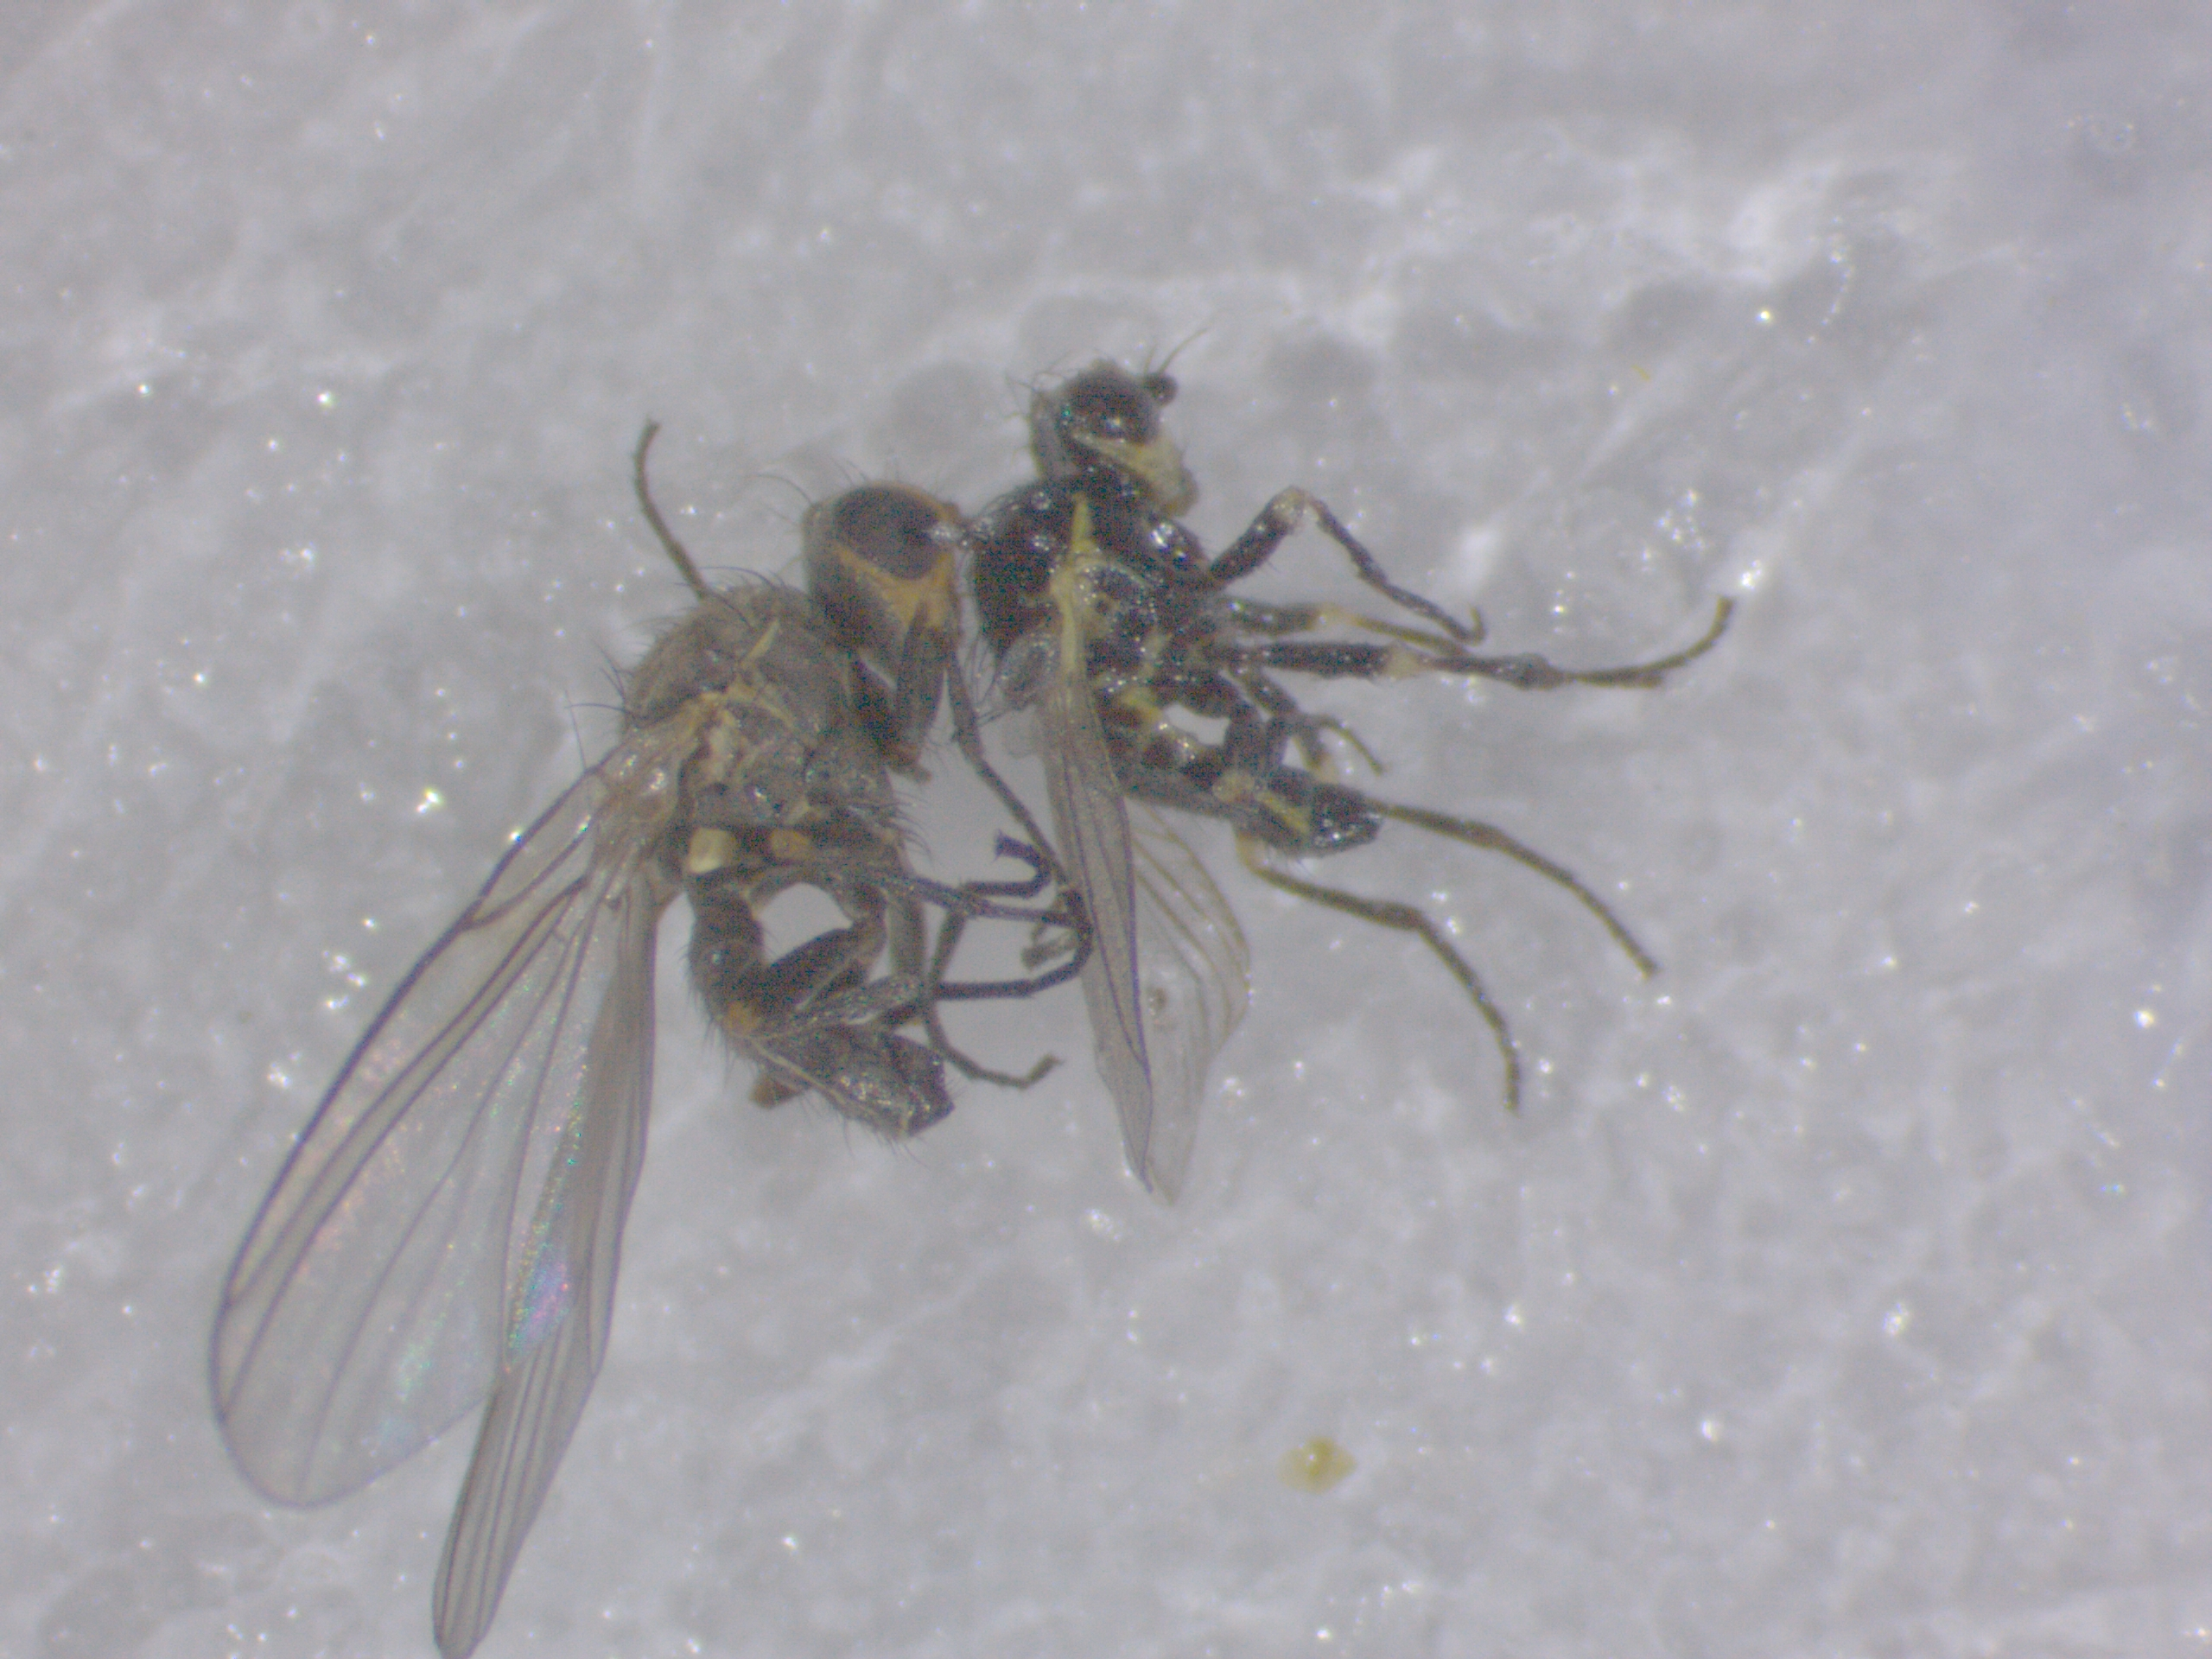

In [1]:
from IPython.display import Image
PATH = "./temp_data/snap258.jpg"
Image(filename = PATH, width=700, height=100)

## Fungus Gnats (infested leek leafminers)

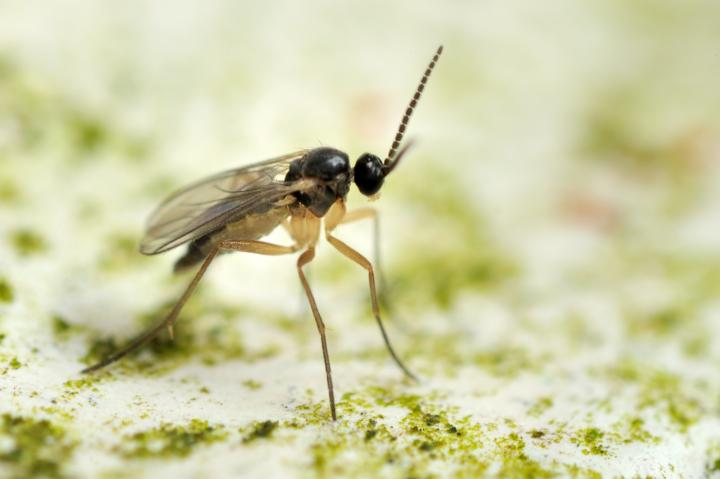

In [2]:
from IPython.display import Image
PATH = "./temp_data/fungus_gnats.jpg"
Image(filename = PATH, width=300, height=100)

## Chorebus glaber (infesting Cichorii leafminers)

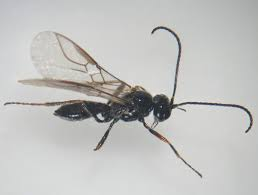

In [3]:
from IPython.display import Image
PATH = "./temp_data/chorebus.jpeg"
Image(filename = PATH, width=300, height=100)

In [4]:
%reset -f
import pandas as pd
import numpy as np
from wavhandler import *
import soundfile as sf

import seaborn as sns
sns.set()
# import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20.0, 10.0))
%matplotlib inline

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [5]:
mydata = Dataset('leek_leafminers')#'leek_leafminers')#'leafminer_all')#LG2/LG_suzukii_18_09_faulty')
mydata.load();

100%|██████████| 3/3 [00:00<00:00, 12.72it/s]


In [6]:
df_feats = mydata.get_sensor_features(temp_humd=False)
df_psd = make_df_parallel(names=mydata.filenames, setting='psd_dB')

In [7]:
# DECIBEL SIGNAL
# df_psd.iloc[:,np.random.randint(0,df_psd.shape[1])].plot()

Text(0.5, 1.0, 'Signal counts for March')

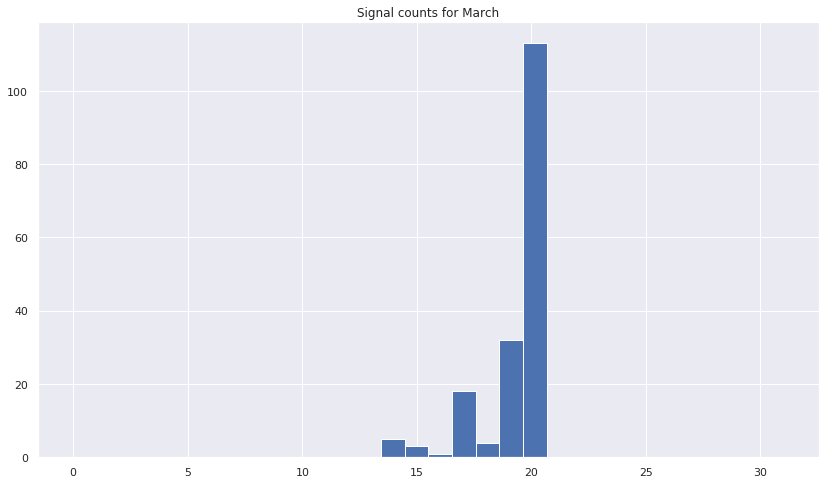

In [8]:
df = df_feats#pd.merge(df_feats.set_index('wavnames'), df_psd.T, left_index=True, right_index=True)
plt.figure(figsize=(14,8))
df.date_day.hist(bins=np.linspace(0,31,31))
plt.title('Signal counts for March')

### Data Table (we have no labels for the signals)

In [9]:
df.head(2)

filenames  \
0  /home/kalfasyan/data/insects/leek_leafminers/D...   
1  /home/kalfasyan/data/insects/leek_leafminers/D...   

                                 wavnames                date  date_day  \
0  F190320_045154_088_G_120_T_27.3_H_67.2 2019-03-20 04:51:54        20   
1  F190319_153356_058_G_120_T_26.6_H_50.2 2019-03-19 15:33:56        19   

   date_hour gain  
0          4  120  
1         15  120

### Some random "traditional" PSD examples

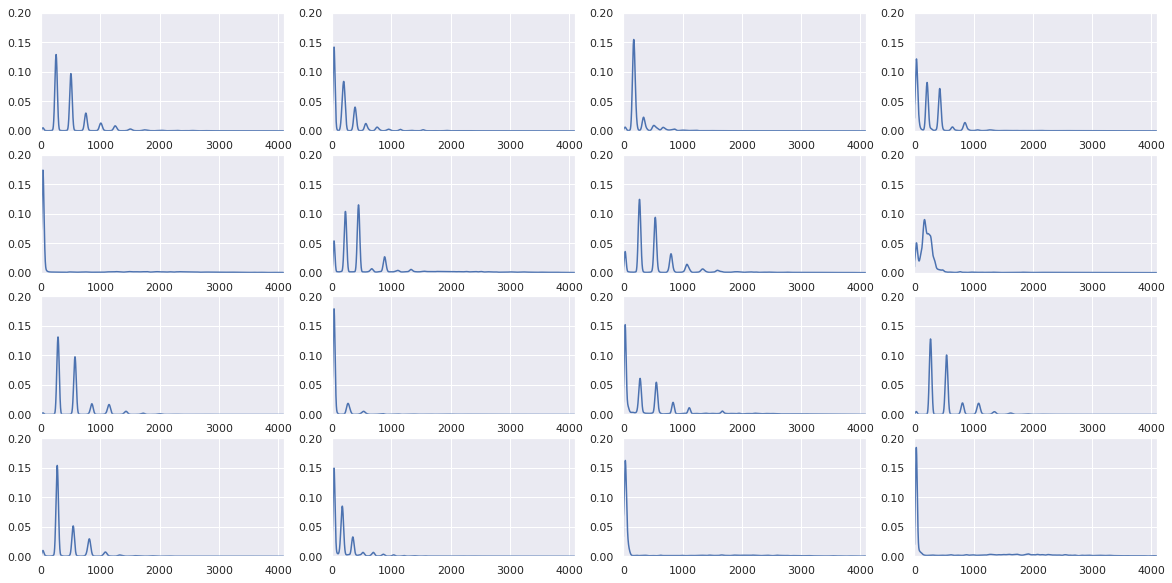

In [10]:

use_log = 0

alldata = read_simple(df.filenames.tolist())[0]
plt.figure(figsize=(20,10))
for i in range(16):
    if use_log:
        from scipy import signal
        psd = 10*np.log10(signal.welch(alldata[:,i], fs=F_S, window='hanning', nperseg=256, noverlap=128+64)[1])
        plt.subplot(4,4,i+1)
        plt.ylim(-100,-60)
        first_bins = -1
        plt.plot( np.linspace(0,4000,129)[:first_bins], psd[:first_bins])
    else:
        psd = power_spectral_density(alldata[:,np.random.randint(0,170)], bandpass=False, nfft=8192, nperseg=256, noverlap=128+64)
        freq = psd.frequency.tolist()
        plt.subplot(4,4,i+1)
        plt.ylim(0,0.20)
        psd.pow_amp.iloc[:].plot()



In [11]:
#from scipy.signal import find_peaks
#x = psd
#peaks = find_peaks(psd, height=-90)[0]

#plt.plot(psd)
#plt.plot(peaks, x[peaks], "x")

## In detail: Signal frequency peaks per day

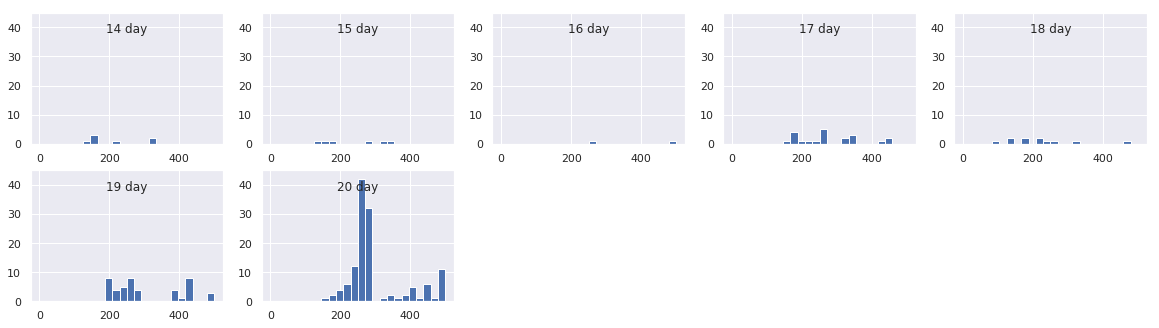

In [12]:
plt.figure(figsize=(20,14))
plt.tight_layout(True)
for w, (q,sub) in enumerate(df.groupby('date_day')):
    alldata = read_simple(sub.filenames.tolist())[0]
    allfreqs = []
    for i in range(alldata.shape[1]):
    #     plt.figure(figsize=(20,12))  
        psd = power_spectral_density(alldata[:,i], bandpass=False, nfft=8192, nperseg=256, noverlap=128+64)
        freq = psd.frequency.tolist()
        
    #     psd.pow_amp.plot()
        allfreqs = allfreqs + [freq[ii] for ii in peak_finder(psd) if ii > 70] ## HIDING THE LOWER FREQUENCY BINS
    plt.subplot(5,5,w+1)
    plt.title(str(q)+' day', y=0.8)
    plt.ylim(0,45)
    plt.hist(allfreqs, bins=np.linspace(0,500,25))

#     #     break

## In more detail: Signal frequency peaks per day and per hour

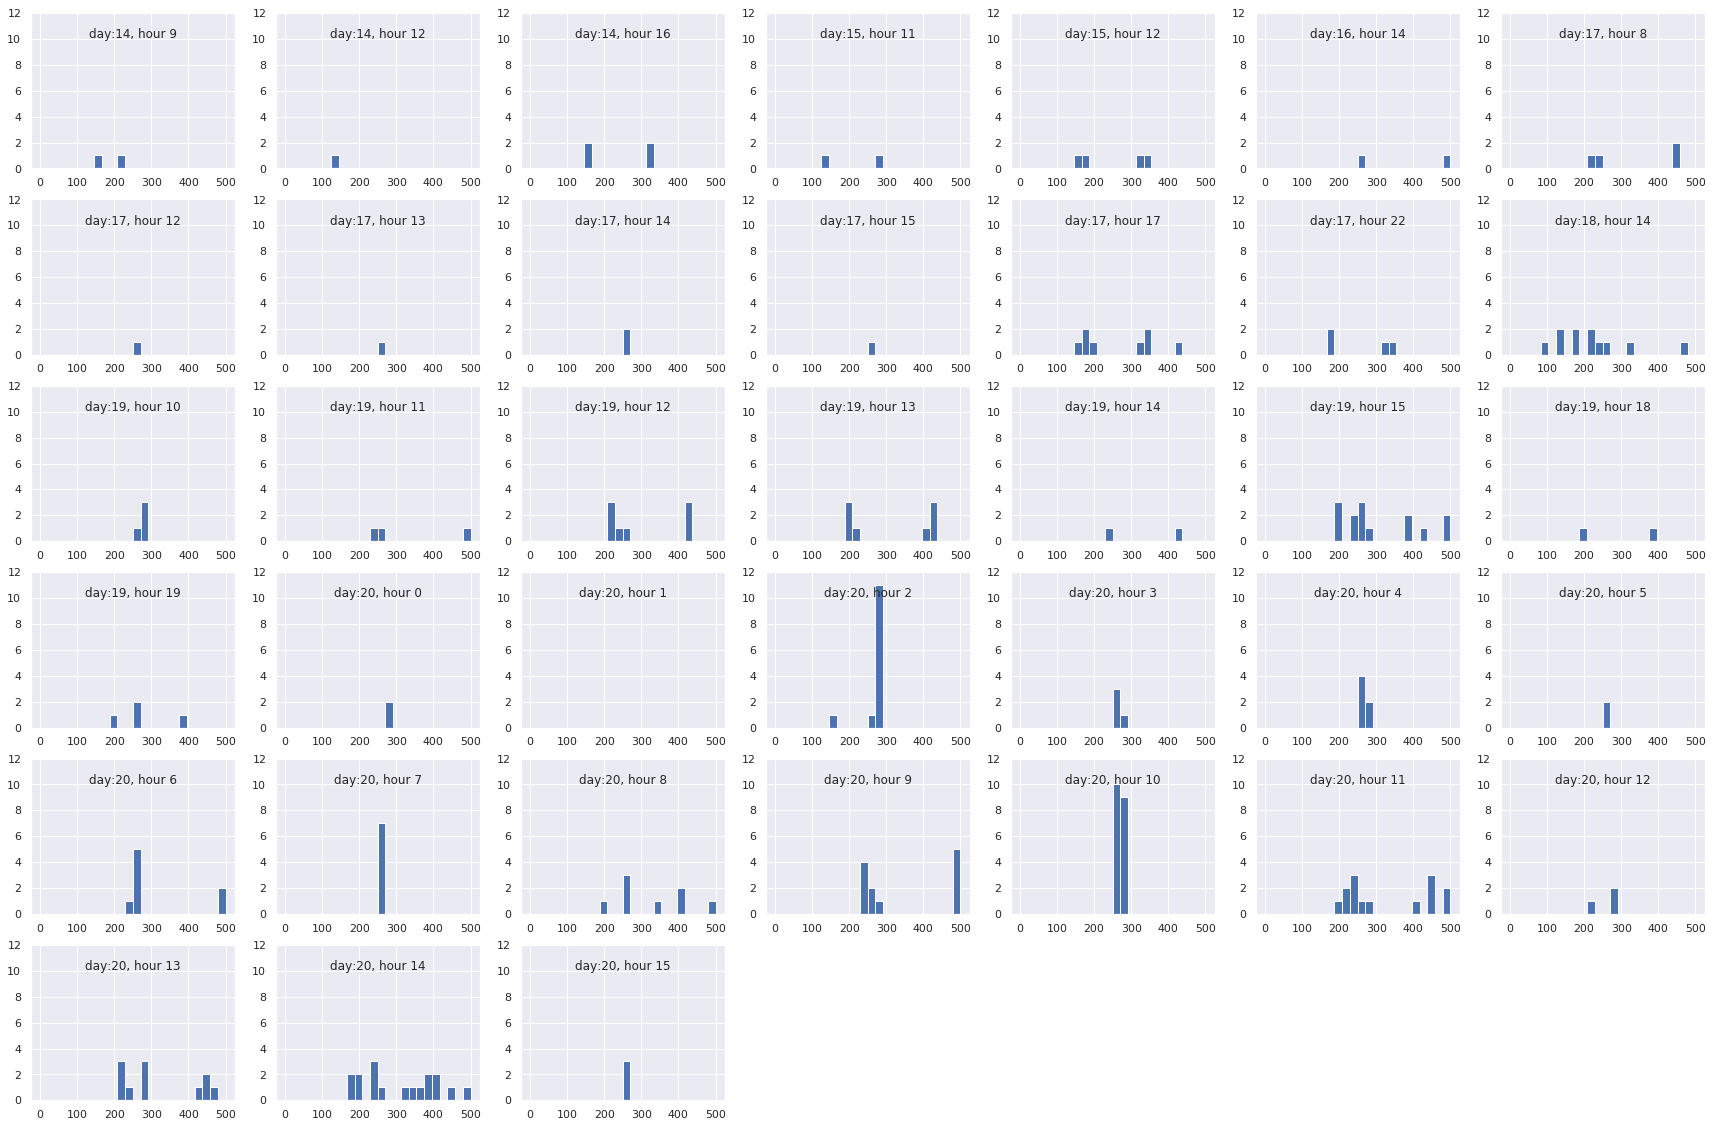

In [13]:
plt.figure(figsize=(30,20))
for w, (q,sub) in enumerate(df.groupby(['date_day', 'date_hour'])):
    title = "day:{}, hour {}".format(sub.date_day.unique()[0], sub.date_hour.unique()[0])
    alldata = read_simple(sub.filenames.tolist())[0]
    allfreqs = []
    for i in range(alldata.shape[1]):
        psd = power_spectral_density(alldata[:,i], bandpass=False, nfft=8192, nperseg=256, noverlap=128+64)
        freq = psd.frequency.tolist()
        allfreqs = allfreqs + [freq[ii] for ii in peak_finder(psd, h_threshold=0.01, d_threshold=3) if ii > 70]
    plt.subplot(6,7,w+1)
    plt.title(title, y=0.8)
    plt.ylim(0,12)
    plt.hist(allfreqs, bins=np.linspace(0,500,25))


## PCA on dB signal to see if we get groupings

In [14]:
df_pca = make_df_parallel(names=mydata.filenames, setting='psd_dB')
print(df_pca.shape)
df_pca.head()

(129, 176)


0          1          2          3          4          5    \
0 -84.944714 -83.564179 -80.739455 -83.619305 -80.628961 -83.807110   
1 -77.706740 -73.043430 -69.093370 -74.421529 -72.366123 -75.234616   
2 -84.959378 -82.803064 -79.523500 -83.534095 -79.721591 -80.634837   
3 -90.381258 -90.161331 -87.193000 -91.269468 -87.366763 -89.047255   
4 -91.213165 -92.147771 -86.363556 -91.874163 -90.080137 -92.209660   

         6          7          8          9    ...        166        167  \
0 -82.909205 -79.205939 -78.086159 -70.680202  ... -63.897716 -77.887642   
1 -73.652007 -73.503453 -69.914252 -63.222312  ... -56.632445 -68.218639   
2 -81.903538 -73.805968 -78.613318 -69.501347  ... -64.373643 -77.668909   
3 -87.996639 -73.049414 -89.132425 -79.978798  ... -76.920218 -87.035971   
4 -89.652482 -73.604700 -86.854400 -81.284071  ... -86.163265 -92.132191   

         168        169        170        171        172        173  \
0 -79.648700 -78.252682 -71.809967 -83.592210 -81.489799 -71.601751   
1 -72.542392 -68.177622 -63.539683 -73.577672 -73.400044 -64.109802   
2 -77.795386 -78.268045 -72.506157 -82.416393 -80.930425 -65.245653   
3 -88.684378 -89.667649 -87.004603 -88.753957 -88.495870 -67.255746   
4 -92.705581 -88.182468 -89.792003 -90.663051 -91.162868 -70.093511   

         174        175  
0 -73.859380 -86.070188  
1 -66.434972 -79.388922  
2 -67.900804 -80.865817  
3 -69.831871 -82.151717  
4 -73.939258 -82.592666  

[5 rows x 176 columns]

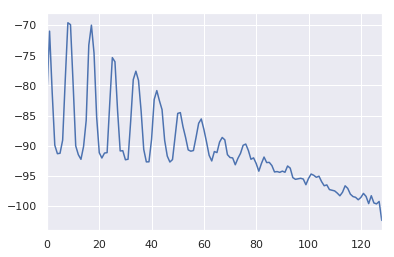

In [15]:
df_pca.iloc[:,np.random.randint(0,175)].plot()

In [16]:
# df_pca.columns = df.index
# df_pca.head()
df.date_day.values.shape
# X.shape
yy = df.date_day.values
yy.shape

(176,)

(176, 129)
(176, 129)
(176, 2)
EXPLAINED VARIANCE with 2 components: 0.61
(176,)


Text(0, 0.5, 'component 2')

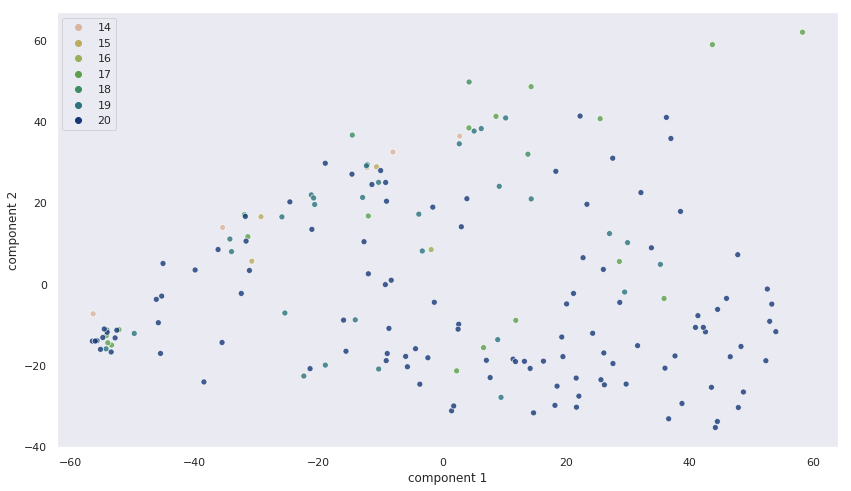

In [17]:
X = df_pca.T.values
print(X.shape)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data
print(X_std.shape)
ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
X_final = pca.fit_transform(X_std)
print(X_final.shape)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )
print(df.date_day.shape)
plt.figure(figsize=(14,8))
sns.set_style("darkgrid", {'axes.grid' : False})
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.8, legend='full', hue=yy, palette=sns.color_palette("gist_earth_r", len(np.unique(yy)))) 

plt.xlabel('component 1')
plt.ylabel('component 2')

## Transfer Learning (1D Convolutional Neural Network)

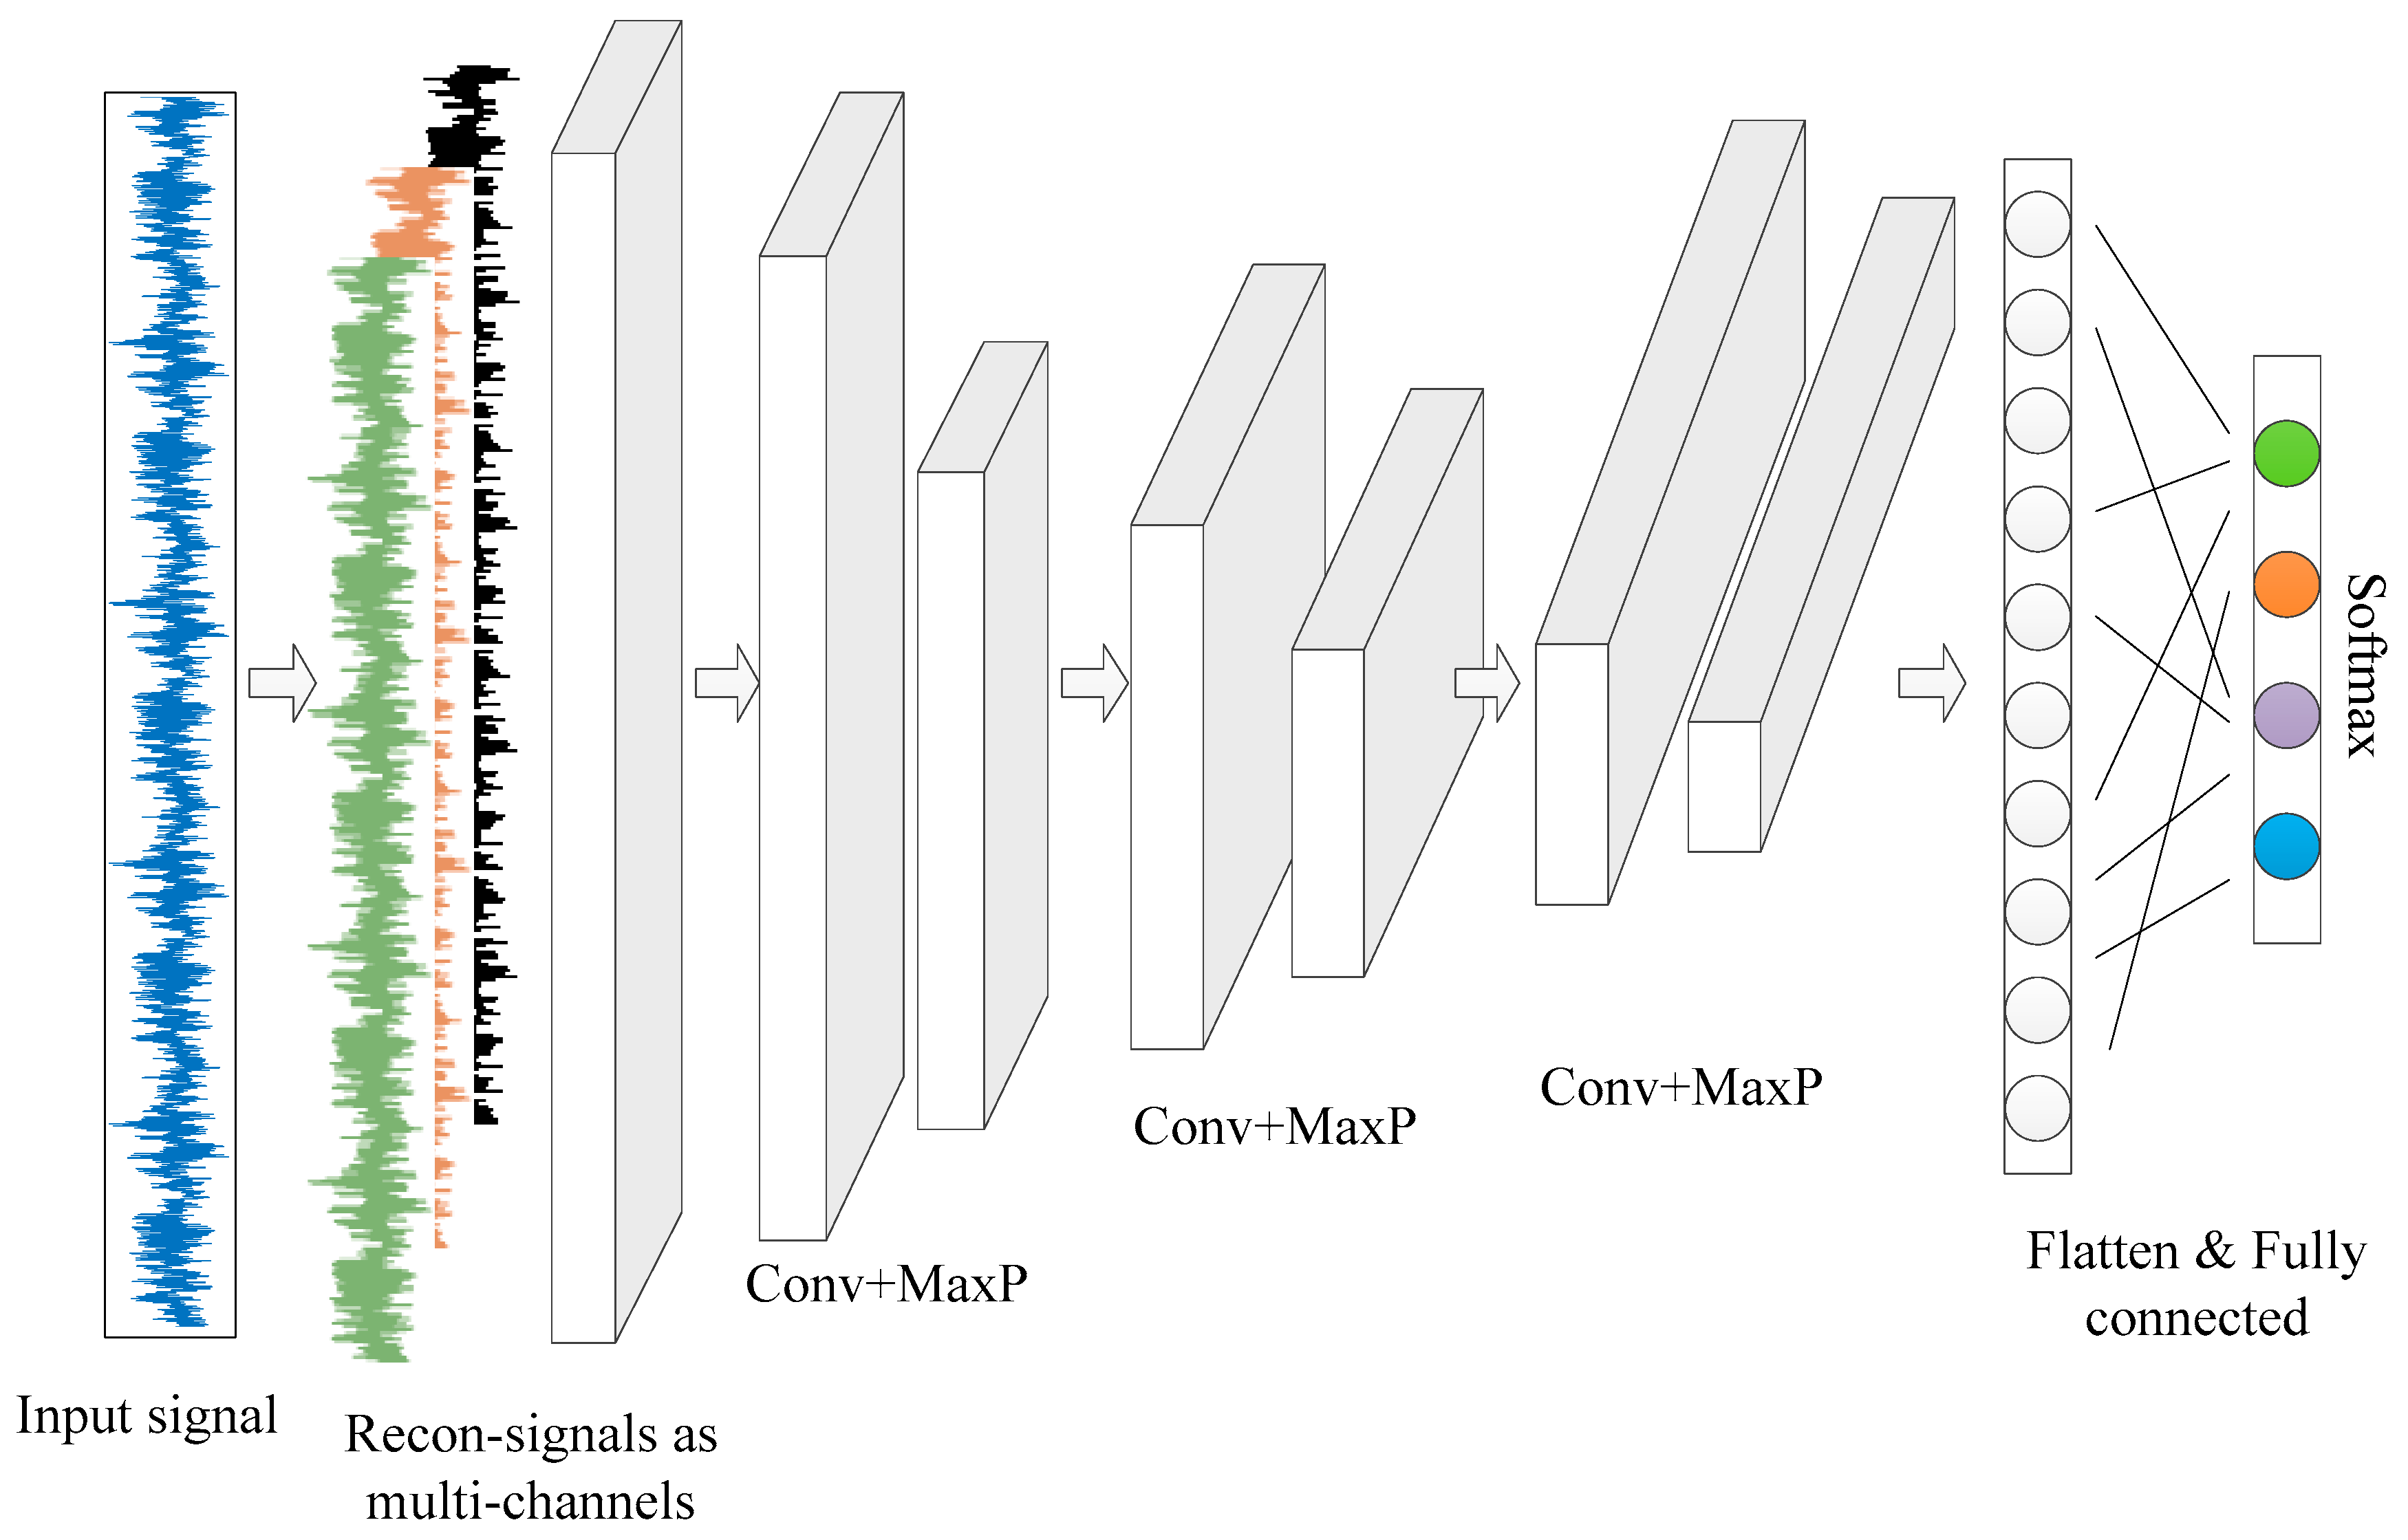

In [18]:
from IPython.display import Image
PATH = "./temp_data/conv1D.png"
Image(filename = PATH, width=800, height=100)

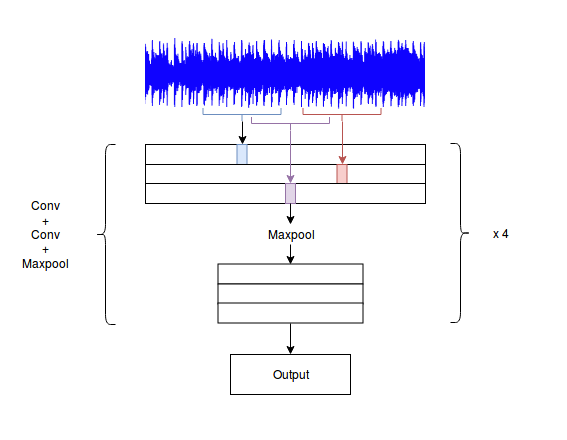

In [19]:
from IPython.display import Image
PATH = "./temp_data/conv1D_2.png"
Image(filename = PATH, width=720, height=300)

## Using a network trained on LG dataset (Zaprionus Drosophila - 99% test accuracy)

In [20]:
from utils import *
from keras.models import model_from_yaml
from wavhandler import read_simple
model_name = 'raw_LG'
yaml_file = open(TEMP_DATADIR + model_name + '.yaml', 'r')
model = yaml_file.read()
yaml_file.close()
model = model_from_yaml(model)

Using TensorFlow backend.


In [21]:
data = read_simple(df.filenames)[0].T
data = np.expand_dims(data, axis=-1)

In [22]:
model.load_weights(TEMP_DATADIR + model_name + '_weights.h5')

In [23]:
from keras.models import Model
layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)

In [24]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [25]:
d = model.predict(data)#intermediate_output#model.predict(data)

# Scatterplot of two neurons (from the last layer)

Text(0, 0.5, 'Neuron 2')

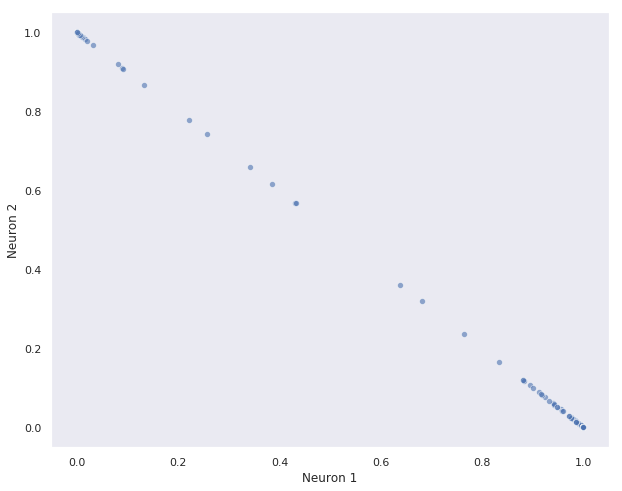

In [26]:
plt.figure(figsize=(10,8))
sns.scatterplot(d[:,0], d[:,1], alpha=0.6)
plt.xlabel('Neuron 1')
plt.ylabel('Neuron 2')

Text(0.5, 1.0, 'Neuron 1')

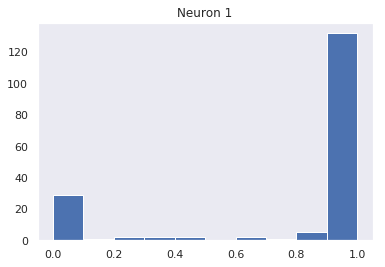

In [27]:
plt.hist(d[:,0]); plt.title('Neuron 1')

Text(0.5, 1.0, 'Neuron 2')

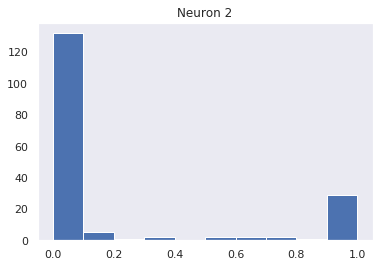

In [28]:
plt.hist(d[:,1]); plt.title('Neuron 2')

## Separating signals based on whether they activated neuron1 or neuron2 more

In [29]:
from scipy.special import softmax
df['label'] = np.argmax(softmax(d, axis=1), axis=1)
df.sample(2)

filenames  \
8   /home/kalfasyan/data/insects/leek_leafminers/D...   
39  /home/kalfasyan/data/insects/leek_leafminers/D...   

                                  wavnames                date  date_day  \
8   F190319_151719_051_G_120_T_27.3_H_70.2 2019-03-19 15:17:19        19   
39  F190319_114244_035_G_120_T_27.3_H_64.3 2019-03-19 11:42:44        19   

    date_hour gain  label  
8          15  120      0  
39         11  120      0

In [30]:
print("DEEPNET claims there are {} signals from gnats and {} signals from leafminers".format(df.label.value_counts()[0], df.label.value_counts()[1]))

DEEPNET claims there are 140 signals from gnats and 36 signals from leafminers


## Coloring the PCA plot with the new labels

In [31]:
zz = 19

EXPLAINED VARIANCE with 2 components: 0.61


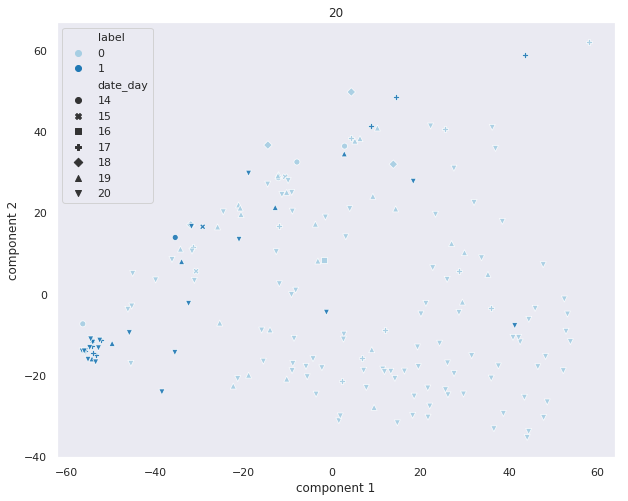

In [48]:
yday = df.date_day#(df.date_day <= zz).astype(int)
hue = {'day': yday, 'deep': df.label}
hue = hue['deep']

X = df_pca.T.values
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data
ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
X_final = pca.fit_transform(X_std)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )
plt.figure(figsize=(10,8))
sns.set_style("darkgrid", {'axes.grid' : False})
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.9, legend='full', palette=sns.color_palette("Paired", len(np.unique(hue))), hue=hue, style=yday)#df.label)#yday)#
plt.title(zz)
plt.xlabel('component 1')
plt.ylabel('component 2')
zz += 1

# Transfer Learning using a network trained on 6 mosquito classes and 2 drosophila classes (~5k-6k signals each)

In [33]:
from utils import *
from keras.models import model_from_yaml
from wavhandler import read_simple
model_name = 'raw_BIG'
yaml_file = open(TEMP_DATADIR + model_name + '.yaml', 'r')
model = yaml_file.read()
yaml_file.close()
model = model_from_yaml(model)
model.load_weights(TEMP_DATADIR + model_name + '_weights.h5')
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
data = read_simple(df.filenames)[0].T
data = np.expand_dims(data, axis=-1)
d = model.predict(data)
d.shape

(176, 8)

## k-means clustering with 2 clusters on the extracted features (of length=8) 

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(d)

In [35]:
print("DEEPNET claims there are {} signals from gnats and {} signals from leafminers".format(pd.Series(kmeans.labels_).value_counts()[0], pd.Series(kmeans.labels_).value_counts()[1]))

DEEPNET claims there are 153 signals from gnats and 23 signals from leafminers


## PCA on extracted features using 2 components and labeling with k-means cluster labels

EXPLAINED VARIANCE with 2 components: 0.64


Text(0, 0.5, 'component 2')

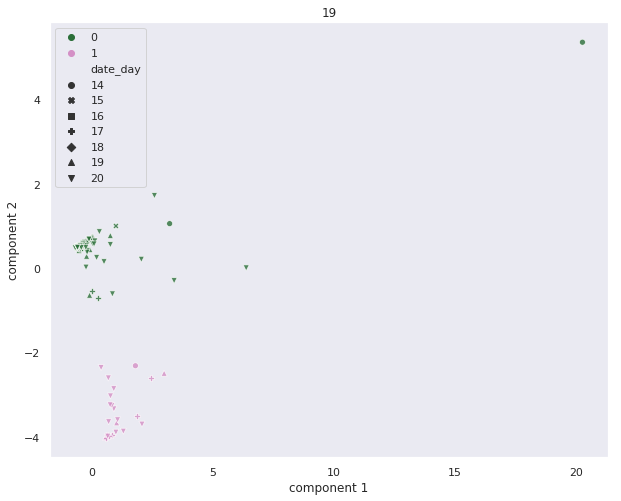

In [49]:
zz = 19
yday = df.date_day#(df.date_day <= 21).astype(int)
hue = {'day': yday, 'deep': kmeans.labels_}
hue = hue['deep']

X = d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=True).fit_transform(X);  # standardization of data
ncomps = 2
pca = PCA(n_components=ncomps)
X_final = pca.fit_transform(X_std)
X_final[40,:] = X_final[40,:]/X_final[40,:] # NOTE: THIS IS TEMPORARY TO REMOVE/CHANGE OUTLIER

print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )
plt.figure(figsize=(10,8))
sns.set_style("darkgrid", {'axes.grid' : False})
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.8, legend='full', palette=sns.color_palette("cubehelix", len(np.unique(hue))), hue=hue, style=yday)#df.label)#yday)#
plt.title(zz)
plt.xlabel('component 1')
plt.ylabel('component 2')

In [37]:
# plt.hist(np.mean(X_final, axis=1))
# plt.ylim(0,155)

In [38]:
# np.argmax(np.mean(X_final, axis=1))

In [39]:
# print(X_final.shape)
# np.delete(X_final, 40, axis=0).shape
# #print(X_final.shape)

### The original PCA (from decibel signals) with k-means labels

EXPLAINED VARIANCE with 2 components: 0.61


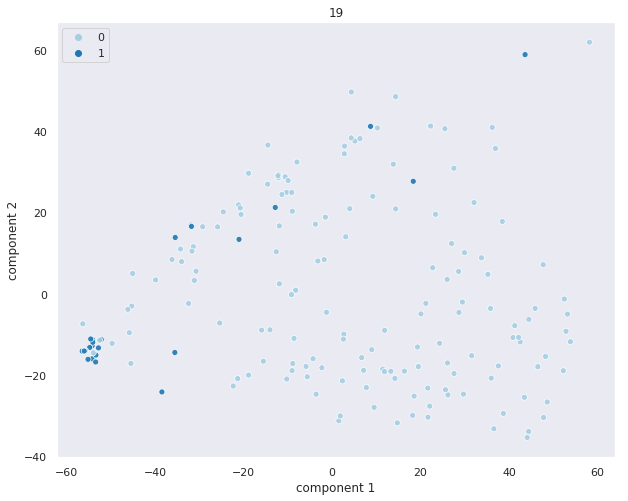

In [40]:
zz = 19
yday = (df.date_day <= zz).astype(int)
hue = {'day': yday, 'deep': df.label}
hue = kmeans.labels_

X = df_pca.T.values
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data
ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
X_final = pca.fit_transform(X_std)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )
plt.figure(figsize=(10,8))
sns.set_style("darkgrid", {'axes.grid' : False})
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.9, legend='full', palette=sns.color_palette("Paired", len(np.unique(hue))), hue=hue)#df.label)#yday)#
plt.title(zz)
plt.xlabel('component 1')
plt.ylabel('component 2')
zz += 1

## Days when signals with kmeans_label=0 appeaered

(153, 8)


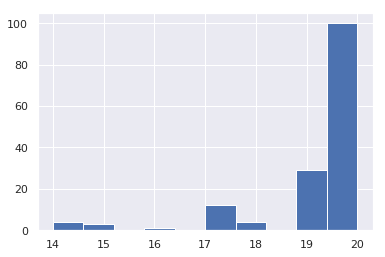

In [52]:
df['kmeans'] = kmeans.labels_
print(df[df.kmeans==0].shape)
df[df.kmeans==0].date_day.hist()

# Do the two Deepnets give common labels?

In [53]:
"The two deepnets agree on {[0]}% of the cases".format((df.label == kmeans.labels_).sum() / df.label.shape * 100.)


'The two deepnets agree on 92.61363636363636% of the cases'

# NEXT STEP: Train deepnet on 4 mosquito classes and see if it can split the other 2 (and verify since we have labels for that dataset)